In [1]:
import pandas as pd
import json
import os
import torch
import scipy
import matplotlib.pyplot as plt
import anndata as ad

import warnings 
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *
from utils.BayesSpace import *

In [2]:
grid_size = 50
num_clusters = 5
data_dimension = 5
random_seed = 1
r = 1

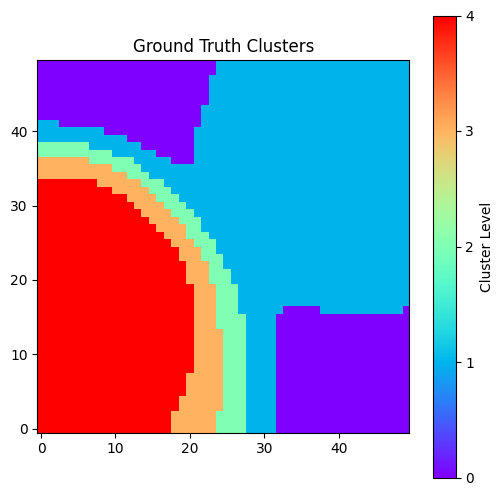

[-1.85535937  4.04186255 -0.95228016  3.08862541  0.81053303] [[2.4887799  0.         0.         0.         0.        ]
 [0.         1.10497931 0.         0.         0.        ]
 [0.         0.         1.26053098 0.         0.        ]
 [0.         0.         0.         0.43709112 0.        ]
 [0.         0.         0.         0.         1.30780163]]
[ 1.01939909  1.81791175 -0.75413555 -2.17643892 -3.61932162] [[2.37373841 0.         0.         0.         0.        ]
 [0.         0.80503623 0.         0.         0.        ]
 [0.         0.         0.05964982 0.         0.        ]
 [0.         0.         0.         0.33034402 0.        ]
 [0.         0.         0.         0.         0.35332062]]
[-2.47550277 -0.45159793  4.55002626 -0.0224897  -4.2889903 ] [[0.59966493 0.         0.         0.         0.        ]
 [0.         1.14816772 0.         0.         0.        ]
 [0.         0.         1.98996892 0.         0.        ]
 [0.         0.         0.         0.7057492  0.        ]


In [3]:
# Set grid dimensions and random seed
np.random.seed(random_seed)

# Step 1: Initialize an empty grid and randomly assign cluster "patches"
ground_truth = np.zeros((grid_size, grid_size), dtype=int)
for cluster_id in range(1, num_clusters):
    # Randomly choose a center for each cluster
    center_x, center_y = np.random.randint(0, grid_size, size=2)
    radius = np.random.randint(10, 30)  # Random radius for each cluster region

    # Assign cluster_id to a circular region around the chosen center
    for i in range(grid_size):
        for j in range(grid_size):
            if (i - center_x) ** 2 + (j - center_y) ** 2 < radius ** 2:
                ground_truth[i, j] = cluster_id

# Step 2: Add random noise within each patch
noise_level = 0.5
noisy_grid = ground_truth + noise_level * np.random.randn(grid_size, grid_size)

# Step 3: Apply Gaussian smoothing to create spatial clustering
sigma = 3  # Controls the amount of clustering smoothness
smoothed_grid = scipy.ndimage.gaussian_filter(noisy_grid, sigma=sigma)

# Step 4: Threshold to obtain integer values
clustered_grid = np.round(smoothed_grid).astype(int)
clustered_grid = np.clip(clustered_grid, 0, num_clusters)

# Plot the clustered grid with flipped y axis
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.imshow(clustered_grid, cmap="tab20", interpolation="nearest", origin='lower')  # Flip y axis by setting origin to 'lower'
ax.set_title("Ground Truth Clusters")
plt.colorbar(ax.imshow(clustered_grid, cmap="rainbow", interpolation="nearest", origin='lower'), ax=ax, label="Cluster Level", ticks=range(num_clusters + 1))  # Flip y axis by setting origin to 'lower'
import os
os.makedirs("results/SYNTHETIC", exist_ok=True)
plt.savefig("results/SYNTHETIC/ground_truth.png")

plt.show()

def find_indices_within_distance(grid, r=1):
    indices_within_distance = np.empty((grid.shape[0], grid.shape[1]), dtype=object)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            # Check all neighboring cells within a Manhattan distance of 1
            neighbors = []
            for x in range(max(0, i-r), min(grid.shape[0], i+r+1)):
                for y in range(max(0, j-r), min(grid.shape[1], j+r+1)):
                    if abs(x - i) + abs(y - j) <= r:
                        neighbors.append((x, y))
            indices_within_distance[i, j] = neighbors
    return indices_within_distance

# get the rook neighbors for each spot
indices = find_indices_within_distance(clustered_grid, r=r)

prior_weights = np.zeros((clustered_grid.shape[0] * clustered_grid.shape[1], num_clusters))

# for each spot sample 
for i in range(clustered_grid.shape[0]):
    for j in range(clustered_grid.shape[1]):
        for neighbor in indices[i, j]:
            prior_weights[i * clustered_grid.shape[1] + j, clustered_grid[neighbor]] += 1
prior_weights = prior_weights / prior_weights.sum(axis=1, keepdims=True)

# Initialize lists for means, covariances, and data points
means = []
covariances = []
data = np.empty((clustered_grid.shape[0] * clustered_grid.shape[1], data_dimension))

# Generate means and covariances for each cluster
for i in range(num_clusters):
    # Randomly set the mean close to the origin to encourage overlap
    mean = np.random.uniform(-5, 5, data_dimension)
    # Generate a diagonal covariance matrix with random magnitudes
    covariance = np.diag(np.random.rand(data_dimension) * 2.5)
    
    means.append(mean)
    covariances.append(covariance)

for mean, covariance in zip(means, covariances):
    print(mean, covariance)
    
# Generate samples from the mixture.
for i, weights in enumerate(prior_weights):
    data[i] = np.sum(weights[k] * np.random.multivariate_normal(means[k], covariances[k], 1) for k in range(num_clusters))

# Create an anndata object
synthetic_adata = ad.AnnData(data)

# Add row and col index
synthetic_adata.obs['spot_number'] = np.arange(clustered_grid.shape[0] * clustered_grid.shape[1])
synthetic_adata.obs['spot_number'] = synthetic_adata.obs['spot_number'].astype('category')
synthetic_adata.obs['row'] = np.repeat(np.arange(clustered_grid.shape[0]), clustered_grid.shape[1])
synthetic_adata.obs['col'] = np.tile(np.arange(clustered_grid.shape[1]), clustered_grid.shape[0])
clustering = XeniumCluster(data=synthetic_adata.X, dataset_name="SYNTHETIC")
clustering.xenium_spot_data = synthetic_adata

Xenium_to_BayesSpace(clustering.xenium_spot_data, dataset_name="SYNTHETIC", spot_size=grid_size)

In [4]:
def run_experiment(synthetic_adata, dataset_name: str, current_spot_size: int, third_dim: bool, init_method: str = "mclust", num_pcs: int = 15, n_clusters=15):
    
    clustering = XeniumCluster(data=synthetic_adata.X, dataset_name="SYNTHETIC")
    clustering.xenium_spot_data = synthetic_adata
    clustering.set_spot_size(current_spot_size)

    BayesSpace_cluster = clustering.BayesSpace(clustering.xenium_spot_data, init_method=init_method, num_pcs=num_pcs, K=n_clusters, grid_search=True)

    return clustering, BayesSpace_cluster

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from scipy.spatial.distance import cdist

def record_results(original_data, cluster_dict, results_dir, model_name, filename, spot_size, third_dim, num_pcs, init_method, K=None, resolution=None, uses_spatial=True):

    dirpath = f"{results_dir}/{model_name}/{num_pcs}/{(str(resolution) if resolution is not None else str(K))}/clusters/{init_method}/{spot_size}"
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

    for gamma in np.linspace(1, 3, 9):
        gamma_str = f"{gamma:.2f}"
        new_dirpath = os.path.join(dirpath, gamma_str)
        if not os.path.exists(new_dirpath):
            os.makedirs(new_dirpath)
        try:
            current_clustering = pd.read_csv(f"{dirpath}/{gamma_str}/{filename}.csv", index_col=0)["BayesSpace cluster"].values

            original_data.xenium_spot_data.obs[f"{model_name} cluster"] = current_clustering
            # Extracting row, col, and cluster values from the dataframe
            rows = torch.tensor(original_data.xenium_spot_data.obs["row"].astype(int))
            cols = torch.tensor(original_data.xenium_spot_data.obs["col"].astype(int))
            clusters = torch.tensor(original_data.xenium_spot_data.obs[f"{model_name} cluster"].astype(int))
            cluster_labels = np.unique(clusters)
            num_clusters = len(cluster_labels)

            num_rows = int(max(rows) - min(rows) + 1)
            num_cols = int(max(cols) - min(cols) + 1)

            cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)

            cluster_grid[rows, cols] = torch.tensor(clusters, dtype=torch.int)

            # colors = plt.cm.get_cmap('viridis', num_clusters + 1)
            # colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
            # colormap = ListedColormap(colormap_colors)

            # plt.figure(figsize=(6, 6))
            # plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
            # plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
            # plt.title(f'Cluster Assignment with BayesSpace ($\gamma$ = {gamma})')

            # plt.savefig(
            #     os.path.join(new_dirpath, f"clusters_K={K}.png")
            # )
            
            mpd = {}
            for label in cluster_labels:
                current_cluster_locations = torch.stack(torch.where((cluster_grid == label)), axis=1).to(float)
                mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations)).item()
                print(f"POSSIBLE {len(cluster_labels)}", label, mpd[f"Cluster {label}"])

            mpd_dirpath = f"{results_dir}/{model_name}/{num_pcs}/{(str(resolution) if resolution is not None else str(K))}/mpd/{init_method}/{spot_size}/{gamma_str}"
            if not os.path.exists(mpd_dirpath):
                os.makedirs(mpd_dirpath)

            mpd_filename = f"{filename}_mpd.json"
            print(os.path.join(mpd_dirpath, mpd_filename))
            with open(os.path.join(mpd_dirpath, mpd_filename), "w") as f:
                json.dump(mpd, f, indent=4)

        except:
            continue

In [6]:
cluster_dict = {"BayesSpace": {}}
mpd = {"BayesSpace": {}}
results_dir = "results/hBreast"

In [7]:
PC_list = [3, 5]
init_methods = ["kmeans", "mclust"]

In [8]:
import matplotlib
import time
matplotlib.use('Agg')

for grid_size in [50]:
    for third_dim in [False]:
        for K in [5]:
            for num_pcs in PC_list:
                for init_method in init_methods:
                    cluster_results_filename = f"clusters_K={K}"
                    start_time = time.time()
                    original_data, BayesSpace_cluster = run_experiment(synthetic_adata, "SYNTHETIC", grid_size, third_dim, init_method, num_pcs, n_clusters=K)
                    end_time = time.time()
                    print(f"Time taken for the run with spot size {grid_size}, {num_pcs} PCs, {K} clusters, and {init_method} initialization: {end_time - start_time} seconds")

                    record_results(original_data, cluster_dict, results_dir, "BayesSpace", cluster_results_filename, grid_size, third_dim, num_pcs, init_method, K, uses_spatial=True)

Time taken for the run with spot size 50, 3 PCs, 5 clusters, and kmeans initialization: 74.636159658432 seconds
Time taken for the run with spot size 50, 3 PCs, 5 clusters, and mclust initialization: 94.45608496665955 seconds
Time taken for the run with spot size 50, 5 PCs, 5 clusters, and kmeans initialization: 90.77438449859619 seconds
Time taken for the run with spot size 50, 5 PCs, 5 clusters, and mclust initialization: 111.74926495552063 seconds


In [9]:
max_ARI = 0
max_ARI_file = ""
TRUE_ASSIGNMENTS = prior_weights.argmax(axis=1)
for root, dirs, files in os.walk("results/SYNTHETIC/BayesSpace"):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            current_clusters = pd.read_csv(file_path)["BayesSpace cluster"].values
            current_ARI = ARI(TRUE_ASSIGNMENTS, current_clusters)
            if current_ARI > max_ARI:
                max_ARI = current_ARI
                max_ARI_file = file_path
print("Max ARI:", max_ARI, "File:", max_ARI_file)

Max ARI: 0.9570460650997693 File: results/SYNTHETIC/BayesSpace/5/5/clusters/mclust/50/3.00/clusters_K=5.csv


In [10]:
spot_sizes = [50, 75, 100]
in_billions = 1_000_000_000
method="BayesSpace"
for spot_size in spot_sizes:
    for K in [17]:
        for init_method in init_methods:
            for num_pcs in PC_list:
                for gamma in np.linspace(1, 3, 9):
                    gamma_str = f"{gamma:.2f}"
                    cluster_results_filename = f"clusters_K={K}"
                    filename = f"results/hBreast/{method}/{num_pcs}/{K}/mpd/{init_method}/{spot_size}/{gamma_str}/{cluster_results_filename}_mpd.json"
                    if os.path.exists(filename):
                        with open(filename, "r") as mpd_dict:
                            current_mpd = json.load(mpd_dict)
                        print("Method:", method, "Spot Size", spot_size, "Num Clusters:", len(current_mpd), "Num PCs", num_pcs, "\u03B3", f": {gamma_str}", "Initial Method:", init_method, "Total mpd:", sum(current_mpd.values()) / in_billions)

Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 1.00 Initial Method: kmeans Total mpd: 5.9624558694639526e-05
Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 1.25 Initial Method: kmeans Total mpd: 5.9554891019092146e-05
Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 1.50 Initial Method: kmeans Total mpd: 5.937125911239763e-05
Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 1.75 Initial Method: kmeans Total mpd: 5.930996394314775e-05
Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 2.00 Initial Method: kmeans Total mpd: 5.92560812802521e-05
Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 2.25 Initial Method: kmeans Total mpd: 5.8986206971324784e-05
Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 2.50 Initial Method: kmeans Total mpd: 5.8808958494391824e-05
Method: BayesSpace Spot Size 50 Num Clusters: 17 Num PCs 3 γ : 2.75 Initial Method: kmeans Total mpd: 5.866197658418109e-05
Metho